In [1]:
!pip install neptune-client segmentation_models_pytorch hydra-core kekas -U -q 
!pip install --target=/kaggle/working pymap3d==2.1.0 -q
!pip install --target=/kaggle/working strictyaml -q
!pip install --target=/kaggle/working protobuf==3.12.2 -q
!pip install --target=/kaggle/working transforms3d -q
!pip install --target=/kaggle/working zarr -q
!pip install --target=/kaggle/working ptable -q
!pip install --no-dependencies --target=/kaggle/working l5kit==1.1.0 --upgrade -q
!cp ../input/lyft-config-files/agent_motion_config.yaml config.yaml
import l5kit, os, albumentations as A
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from tqdm import tqdm
from l5kit.geometry import transform_points
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
import matplotlib.pyplot as plt
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
# get config
MONITORING = False # set this to false if you want to fork and train
if MONITORING:
    !pip install utilsforlyft
    import utilsforlyft as U
cfg = load_config_data("../input/lyft-config-files/visualisation_config.yaml")
import plotly.offline as py
import omegaconf
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import torch
import torch.nn.functional as F
import torch.nn as nn
from catalyst import dl, data
from catalyst.utils import metrics
from torch.utils.data import DataLoader
from catalyst.dl import utils, BatchOverfitCallback
from torch.optim.lr_scheduler import OneCycleLR
import segmentation_models_pytorch as smp
from catalyst.core.callbacks.early_stop import EarlyStoppingCallback
if MONITORING:
    from catalyst.contrib.dl.callbacks.neptune_logger import NeptuneLogger
    from catalyst.contrib.dl.callbacks import WandbLogger
    neptune_logger = NeptuneLogger(
                    api_token=U.TOKEN + '=',  
                    project_name="trigram19/"+U.NAME_PROJ,
                    offline_mode=False, 
                    name=U.NAME,
                    params={'epoch_nr': 5}, 
                    properties={'data_source': 'lyft'},  
                    tags=['resnet']
                    )

from IPython.display import display, clear_output, HTML
import PIL
import matplotlib.pyplot as plt
from matplotlib import animation as ani, rc
import numpy as np
import warnings; warnings.filterwarnings('ignore')
from l5kit.rasterization.rasterizer_builder import _load_metadata

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

osmnx 0.15.1 requires geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
kubernetes 10.1.0 requires pyyaml~=3.12, but you'll have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.2 which is incompatible.
google-cloud-pubsub 1.4.3 requires google-api-core[grpc]<1.17.0,>=1.14.0, but you'll have googl

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
def plot_image(map_type, ax, agent=False):
    cfg["raster_params"]["map_type"] = map_type
    rast = build_rasterizer(cfg, dm)
    if agent:
        dataset = AgentDataset(cfg, zarr_dataset, rast)
    else:
        dataset = EgoDataset(cfg, zarr_dataset, rast)
    scene_idx = 2
    indexes = dataset.get_scene_indices(scene_idx)
    images = []
    for idx in indexes:    
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        clear_output(wait=True)
        ax.imshow(im[::-1])
                
def animate_solution(images):
    def animate(i):
        im.set_data(images[i]) 
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])    
    return ani.FuncAnimation(fig, animate, frames=len(images), interval=60)

def animation(type_):
    cfg["raster_params"]["map_type"] = type_
    rast = build_rasterizer(cfg, dm)
    dataset = EgoDataset(cfg, zarr_dataset, rast)
    scene_idx = 34
    indexes = dataset.get_scene_indices(scene_idx)
    images = []
    for idx in indexes:    
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
    anim = animate_solution(images)
    return HTML(anim.to_jshtml())

def plot_with_tfms(tf):
    tfms = A.Compose(tf, keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))
    im = tfms(image=train_dataset_a[0]['image'], keypoints=train_dataset_a[0]['target_positions'])
    keypoints = im['keypoints']
    im = train_dataset_a.rasterizer.to_rgb(im['image'].transpose(1, 2, 0))
    plt.imshow(im, cmap='Reds');
    


In [3]:
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"]);rasterizer = build_rasterizer(cfg, dm)
zarr_dataset = ChunkedDataset(dataset_path)
train_dataset_a = AgentDataset(cfg, zarr_dataset, rasterizer)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [11]:
agents = pd.read_csv('../input/lyft-motion-prediction-autonomous-vehicles-as-csv/agents_0_10019001_10019001.csv')
agents

,centroid_x,centroid_y,extent_x,extent_y,extent_z,yaw,velocity_x,velocity_y,track_id,label_probabilities_PERCEPTION_LABEL_UNKNOWN,label_probabilities_PERCEPTION_LABEL_CAR,label_probabilities_PERCEPTION_LABEL_CYCLIST,label_probabilities_PERCEPTION_LABEL_PEDESTRIAN,agent_id,frame_db_id
0,665.034241,-2207.512207,4.391328,1.813830,1.590976,1.016675,0.0,0.0,1,0.0,1.0,0.0,0.0,0,0
1,717.661255,-2173.760010,5.150925,1.953092,2.040210,-0.783224,0.0,0.0,2,0.0,1.0,0.0,0.0,1,0
2,730.681396,-2180.678955,2.948282,1.484217,1.112507,-0.321747,0.0,0.0,3,0.0,1.0,0.0,0.0,2,0
3,671.253601,-2204.745361,1.706702,0.928787,0.628216,0.785501,0.0,0.0,4,1.0,0.0,0.0,0.0,3,0
4,669.776306,-2213.004639,0.251099,0.634378,1.654377,1.492359,0.0,0.0,5,1.0,0.0,0.0,0.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10018996,-942.481567,1455.342163,0.507632,0.390774,0.691540,1.413776,0.0,0.0,651,1.0,0.0,0.0,0.0,10018996,124166
10018997,-970.735779,1429.277954,0.247675,0.705047,1.133533,1.256697,0.0,0.0,652,1.0,0.0,0.0,0.0,10018997,124166
10018998,-1010.673340,1456.704834,0.372908,0.375625,0.939091,0.000060,0.0,0.0,653,1.0,0.0,0.0,0.0,10018998,124166
10018999,-943.069580,1455.282959,1.565054,0.478435,0.904701,0.078600,0.0,0.0,654,1.0,0.0,0.0,0.0,10018999,124166


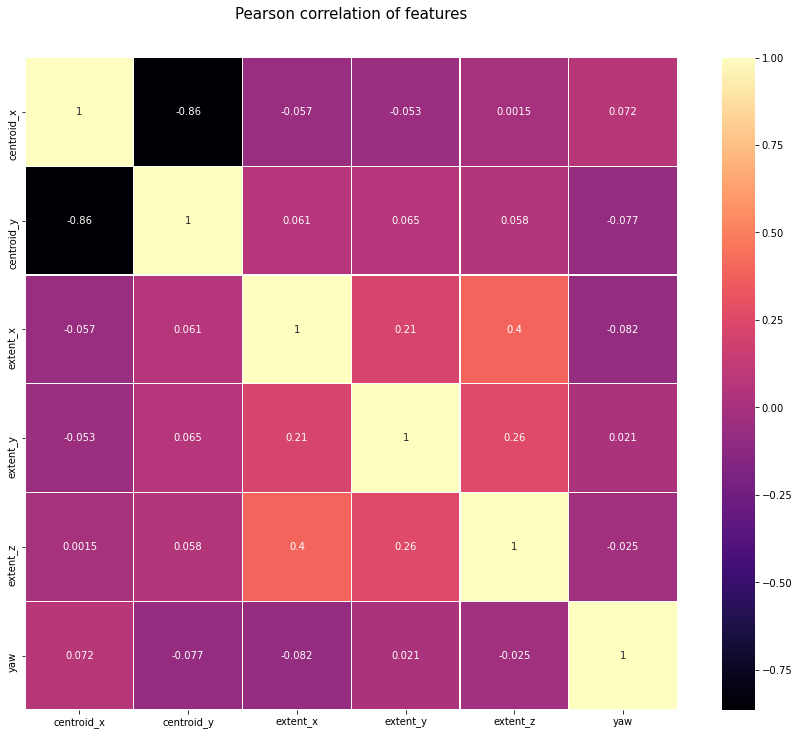

In [12]:
import seaborn as sns
colormap = plt.cm.magma
cont_feats = ["centroid_x", "centroid_y", "extent_x", "extent_y", "extent_z", "yaw"]
plt.figure(figsize=(16,12));
plt.title('Pearson correlation of features', y=1.05, size=15);
sns.heatmap(agents[cont_feats].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [17]:
frms = pd.read_csv("../input/lyft-motion-prediction-autonomous-vehicles-as-csv/frames_0_124167_124167.csv")
frms.head()

,timestamp,agent_index_interval_start,agent_index_interval_end,traffic_light_faces_index_interval_start,traffic_light_faces_index_interval_end,ego_translation_x,ego_translation_y,ego_translation_z,ego_rotation_xx,ego_rotation_xy,ego_rotation_xz,ego_rotation_yx,ego_rotation_yy,ego_rotation_yz,ego_rotation_zx,ego_rotation_zy,ego_rotation_zz,frame_db_id,scene_db_id
0,1572643684801892606,0,38,0,0,680.619751,-2183.327637,288.541138,0.546733,-0.837294,0.004591,0.835287,0.545026,-0.072402,0.058120,0.043419,0.997365,0,0
1,1572643684901714926,38,85,0,0,681.185608,-2182.422363,288.608124,0.547081,-0.837060,0.005748,0.835098,0.545301,-0.072513,0.057564,0.044470,0.997351,1,0
2,1572643685001499246,85,142,0,0,681.764709,-2181.522705,288.680939,0.547960,-0.836487,0.005308,0.834573,0.546253,-0.071379,0.056808,0.043542,0.997435,2,0
3,1572643685101394026,142,200,0,0,682.341431,-2180.624268,288.755920,0.549123,-0.835734,0.003578,0.833714,0.547487,-0.071972,0.058190,0.042504,0.997400,3,0
4,1572643685201412346,200,254,0,0,682.919800,-2179.730469,288.827393,0.550422,-0.834887,-0.000075,0.832540,0.548881,-0.074874,0.062552,0.041149,0.997193,4,0


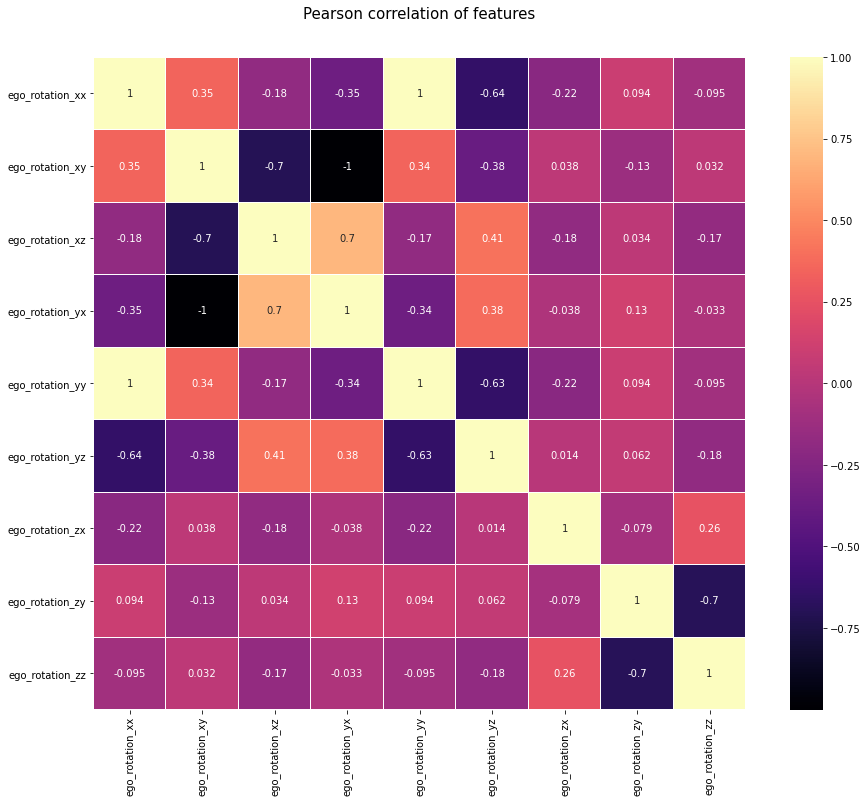

In [18]:
import seaborn as sns
colormap = plt.cm.magma
cont_feats = ["ego_rotation_xx", "ego_rotation_xy", "ego_rotation_xz", "ego_rotation_yx", "ego_rotation_yy", "ego_rotation_yz", "ego_rotation_zx", "ego_rotation_zy", "ego_rotation_zz"]
plt.figure(figsize=(16,12));
plt.title('Pearson correlation of features', y=1.05, size=15);
sns.heatmap(frms[cont_feats].corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True);


In [20]:
tfms = A.Compose([A.Cutout()], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False))
im = tfms(image=train_dataset_a[0]['image'], keypoints=train_dataset_a[0]['target_positions'])
keypoints = im['keypoints']
im = train_dataset_a.rasterizer.to_rgb(im['image'].transpose(1, 2, 0))

In [21]:
cfg2 = load_config_data("../input/lyft-config-files/agent_motion_config.yaml")
cfg2 = omegaconf.OmegaConf.create(cfg2)
train_cfg = omegaconf.OmegaConf.to_container(cfg2.train_data_loader)
validation_cfg = omegaconf.OmegaConf.to_container(cfg2.val_data_loader)
# Rasterizer
rasterizer = build_rasterizer(cfg2, dm)

In [22]:
print(cfg2.pretty())

format_version: 4
model_params:
  model_architecture: resnet50
  history_num_frames: 0
  history_step_size: 1
  history_delta_time: 0.1
  future_num_frames: 50
  future_step_size: 1
  future_delta_time: 0.1
raster_params:
  raster_size:
  - 224
  - 224
  pixel_size:
  - 0.5
  - 0.5
  ego_center:
  - 0.25
  - 0.5
  map_type: py_semantic
  satellite_map_key: aerial_map/aerial_map.png
  semantic_map_key: semantic_map/semantic_map.pb
  dataset_meta_key: meta.json
  filter_agents_threshold: 0.5
train_data_loader:
  key: scenes/sample.zarr
  batch_size: 12
  shuffle: true
  num_workers: 16
val_data_loader:
  key: scenes/sample.zarr
  batch_size: 12
  shuffle: false
  num_workers: 16
train_params:
  checkpoint_every_n_steps: 10000
  max_num_steps: 5
  eval_every_n_steps: 10000



In [23]:
class LyftModel(torch.nn.Module):
    def __init__(self, cfg: omegaconf.dictconfig.DictConfig):
        super().__init__()
        self.backbone = smp.FPN(encoder_name="resnext50_32x4d", classes=1)
        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels
        self.backbone.encoder.conv1 = nn.Conv2d(
            num_in_channels,
             self.backbone.encoder.conv1.out_channels,
            kernel_size= self.backbone.encoder.conv1.kernel_size,
            stride= self.backbone.encoder.conv1.stride,
            padding= self.backbone.encoder.conv1.padding,
            bias=False,
        ) 
        backbone_out_features = 14
        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=14, out_features=4096),
        )
        self.backbone.segmentation_head = nn.Sequential(nn.Conv1d(56, 1, kernel_size=3, stride=2), nn.Dropout(0.2), nn.ReLU())
        self.logit = nn.Linear(4096, out_features=num_targets)
        self.logit_final = nn.Linear(128, 12)
        self.num_preds = num_targets * 3
    def forward(self, x):
        x = self.backbone.encoder.conv1(x)
        x = self.backbone.encoder.bn1(x)        
        x = self.backbone.encoder.relu(x)
        x = self.backbone.encoder.maxpool(x)        
        x = self.backbone.encoder.layer1(x)
        x = self.backbone.encoder.layer2(x)
        x = self.backbone.encoder.layer3(x)
        x = self.backbone.encoder.layer4(x)        
        x = self.backbone.decoder.p5(x)
        x = self.backbone.decoder.seg_blocks[0](x)
        x = self.backbone.decoder.merge(x)
        x = self.backbone.segmentation_head(x)
        x = self.backbone.encoder.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        x = self.logit(x)   
        x = x.permute(1, 0)
        x = self.logit_final(x)
        return x

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftModel(cfg2)
model.to(device)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg2, train_zarr, rasterizer)
del train_cfg['key']
subset = torch.utils.data.Subset(train_dataset, range(0, 1100))
train_dataloader = DataLoader(subset,
                              **train_cfg)
val_zarr = ChunkedDataset(dm.require(validation_cfg['key'])).open()
del validation_cfg['key']

val_dataset = AgentDataset(cfg2, val_zarr, rasterizer)
subset = torch.utils.data.Subset(val_dataset, range(0, 50))
val_dataloader = DataLoader(subset,
                              **validation_cfg)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}

class LyftRunner(dl.SupervisedRunner):
    def predict_batch(self, batch):
        return self.model(batch[0].to(self.device).view(batch[0].size(0), -1))
    def _handle_batch(self, batch):
        x, y = batch['image'], batch['target_positions']
        y_hat = self.model(x).view(y.shape)
        target_availabilities = batch["target_availabilities"].unsqueeze(-1)
        criterion = torch.nn.MSELoss(reduction="none")
        loss = criterion(y_hat, y)
        loss = loss * target_availabilities
        loss = loss.mean()
        self.batch_metrics.update(
            {"loss": loss}
        )


In [26]:
%%time
device = utils.get_device()
runner = LyftRunner(device=device, input_key="image", input_target_key="target_positions", output_key="logits")
if MONITORING:

    runner.train(
        model=model,
        optimizer=optimizer,
        loaders=loaders,
        logdir="../working",
        num_epochs=4,
        verbose=True,
        load_best_on_end=True,
        callbacks=[neptune_logger, BatchOverfitCallback(train=10, valid=0.5), 
                  EarlyStoppingCallback(
            patience=2,
            metric="loss",
            minimize=True,
        ), WandbLogger(project="dertaismus",name= 'Example')
                  ]
    )
else:
    runner.train(
        model=model,
        optimizer=optimizer,
        loaders=loaders,
        logdir="../working",
        num_epochs=4,
        verbose=True,
        load_best_on_end=True,
        callbacks=[BatchOverfitCallback(train=10, valid=0.5), 
                  EarlyStoppingCallback(
            patience=2,
            metric="loss",
            minimize=True,
        )
                  ]
    )
       

1/4 * Epoch (train): 100% 92/92 [01:47<00:00,  1.17s/it, loss=108.116]
1/4 * Epoch (valid): 100% 5/5 [00:06<00:00,  1.32s/it, loss=163.463]
[2021-06-03 22:25:18,388] 
1/4 * Epoch 1 (_base): lr=0.0200 | momentum=0.9000
1/4 * Epoch 1 (train): loss=48.6954
1/4 * Epoch 1 (valid): loss=149.2297
2/4 * Epoch (train): 100% 92/92 [01:52<00:00,  1.22s/it, loss=89.543] 
2/4 * Epoch (valid): 100% 5/5 [00:06<00:00,  1.32s/it, loss=176.552]
[2021-06-03 22:27:26,777] 
2/4 * Epoch 2 (_base): lr=0.0200 | momentum=0.9000
2/4 * Epoch 2 (train): loss=50.1455
2/4 * Epoch 2 (valid): loss=160.6966
3/4 * Epoch (train): 100% 92/92 [01:56<00:00,  1.26s/it, loss=22.637] 
3/4 * Epoch (valid): 100% 5/5 [00:06<00:00,  1.32s/it, loss=227.998]
[2021-06-03 22:29:37,759] 
3/4 * Epoch 3 (_base): lr=0.0200 | momentum=0.9000
3/4 * Epoch 3 (train): loss=46.7267
3/4 * Epoch 3 (valid): loss=183.8863
Early stop at 3 epoch
Top best models:
../working/checkpoints/train.1.pth	149.2297
=> Loading checkpoint ../working/checkpoints